## Trees and Ensembles - Data Science Portfolio - Maximilian Koch

**Dataset**: Diabetes database<br>
**Target variable**: Understanding diabetes factors<br>
**Features**: 8 medical features<br>
**Techniques applied**: CART, pruning, undersampling, oversampling, SMOTE, Random Forest, XGBoost, bagging, voting, stacking, hyperparameter optimization<br>



I chose this dataset on diabetes: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In this notebook, I will:
* Apply pruning to a CART model (decision tree)
* Compare performance to Random Forest and XGBoost model
* Apply resampling methods
* Use ensemble methods

### Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from scipy.stats import beta, norm, bernoulli

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from decimal import Decimal
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('datasets/trees_dataset.csv')

np.random.seed(0)
X = df.drop('Outcome',axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### CART / Decision Tree

In [4]:
cart_model = DecisionTreeClassifier(random_state=0)
cart_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

train f1: 1.0
test f1: 0.7306122448979593


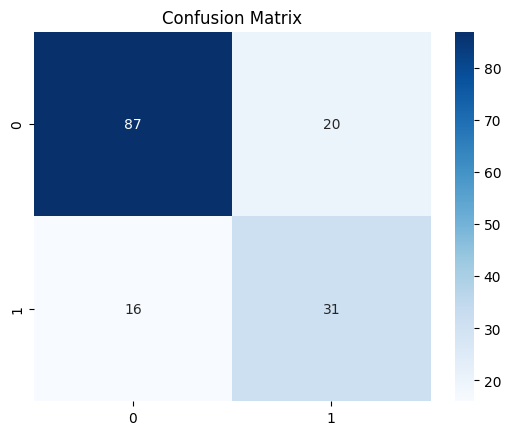

In [5]:
predictions = cart_model.predict(X_test)
#due to the severe class imbalance, standard accuracy is not a good
#measure, f1 score makes more sense,
#especially since it prioritizes false negative and false positives,
#which suits medical application like this one!
from sklearn.metrics import f1_score
print('train f1:', f1_score(y_train,cart_model.predict(X_train),average='macro'))
print('test f1:', f1_score(y_test, predictions, average='macro'))

conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

With a training f1 of 1.0, the Decision Tree is severly overfitting, but still capturing some relevant patterns, as the test f1 is around 0.73.
As seen below, the decision tree goes quite deep/detailed, despite the relatively sparse data.
Thus applying pruning makes a lot of sense.

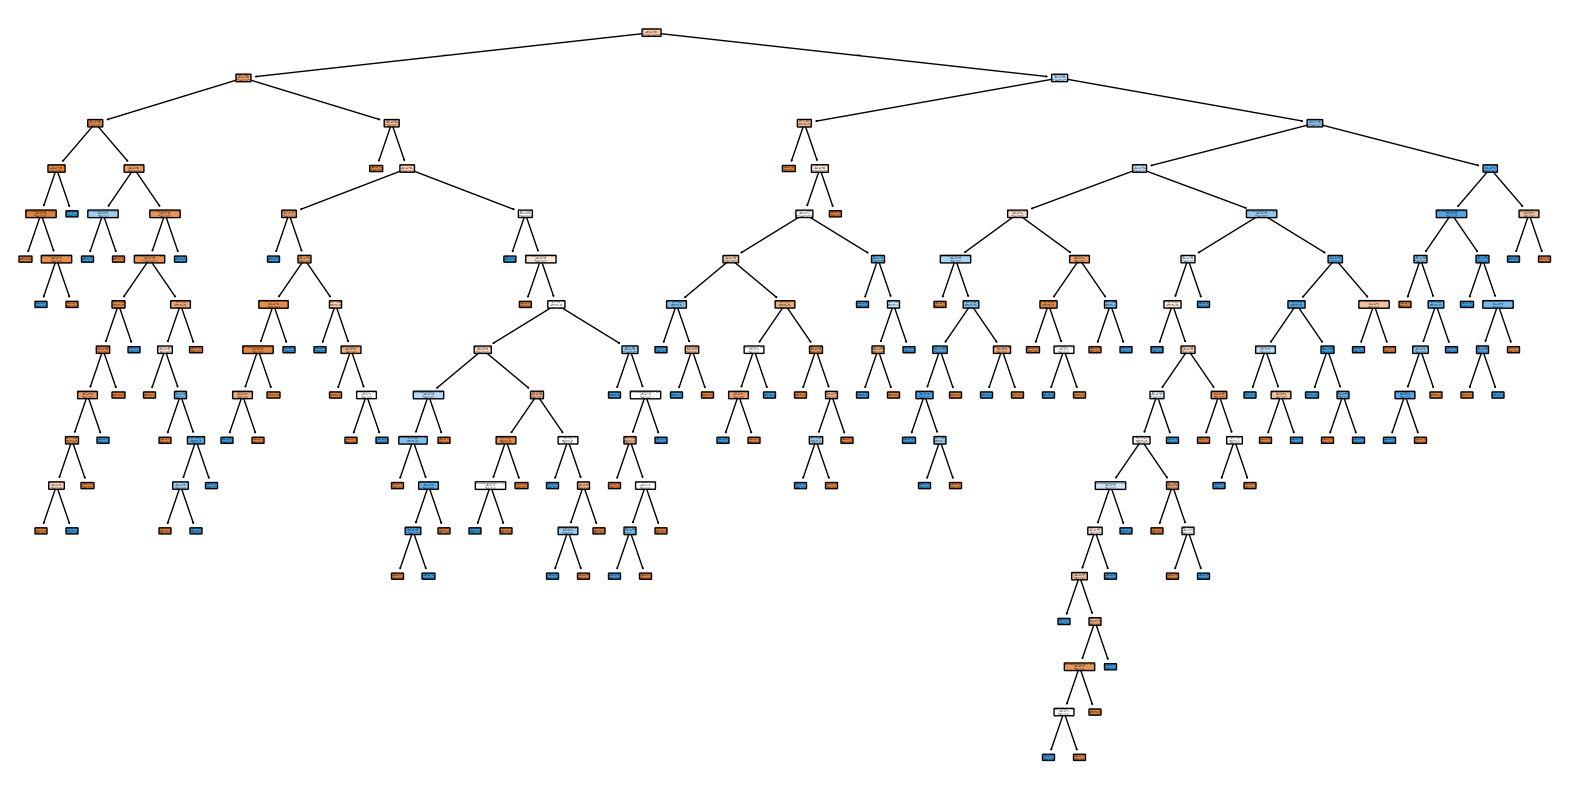

In [6]:
plt.figure(figsize=(20,10))
plot_tree(cart_model, filled=True, rounded=True,
class_names=['yes','no'],feature_names=list(X_train.columns))
plt.show()

### Pruning Decision Tree

Optimising the f1-score by searching for the ideal
max_depth, min_samples_split and ccp alpha at the same time!
Nested for-loop / grid search would be too slow,
thus I used optuna, which uses Bayesian optimization.
Install optuna in case not installed:
!pip install optuna

In [7]:
#finding an approriate range for ccp_alpha:
path = cart_model.cost_complexity_pruning_path(X_train, y_train)
print(min(path.ccp_alphas),max(path.ccp_alphas))

0.0 0.08254962373431213


In [8]:
import optuna

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 7),
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 19),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.1)
    }
    
    model = DecisionTreeClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_test)
    
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    val_f1 = f1_score(y_test, y_val_pred, average='macro')
    
    #train scores need to be manually stored, unlike validation scores
    trial.set_user_attr("train_f1", train_f1)
    return val_f1

tree_study = optuna.create_study(direction='maximize')
tree_study.optimize(objective, n_trials=50)

[I 2025-04-03 11:22:31,669] A new study created in memory with name: no-name-f3da063d-7ed6-4ef8-8e2f-da11f034788d
[I 2025-04-03 11:22:31,681] Trial 0 finished with value: 0.6921002464313943 and parameters: {'max_depth': 5, 'min_samples_split': 15, 'ccp_alpha': 0.0537508592297076}. Best is trial 0 with value: 0.6921002464313943.
[I 2025-04-03 11:22:31,695] Trial 1 finished with value: 0.6921002464313943 and parameters: {'max_depth': 7, 'min_samples_split': 11, 'ccp_alpha': 0.06559052520488326}. Best is trial 0 with value: 0.6921002464313943.
[I 2025-04-03 11:22:31,698] Trial 2 finished with value: 0.4099616858237548 and parameters: {'max_depth': 6, 'min_samples_split': 11, 'ccp_alpha': 0.09462512938272416}. Best is trial 0 with value: 0.6921002464313943.
[I 2025-04-03 11:22:31,711] Trial 3 finished with value: 0.6921002464313943 and parameters: {'max_depth': 4, 'min_samples_split': 14, 'ccp_alpha': 0.047486232375804384}. Best is trial 0 with value: 0.6921002464313943.
[I 2025-04-03 11:2

Let's see how close training and validation f1 are from each other!

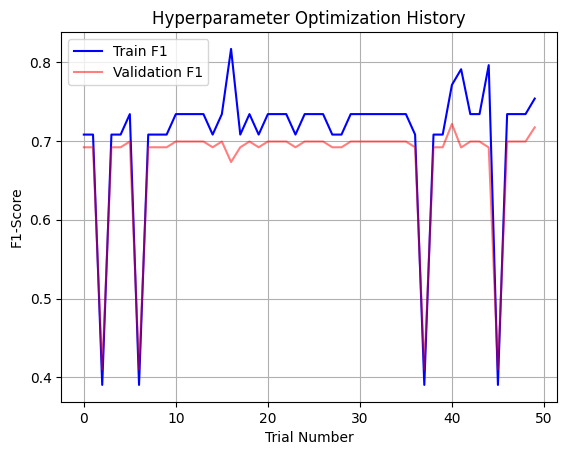

In [9]:
trials = tree_study.trials
trials_df = tree_study.trials_dataframe()

trial_numbers = [t.number for t in trials]
train_scores = [t.user_attrs['train_f1'] for t in trials]
val_scores = [t.value for t in trials]

plt.plot(trial_numbers, train_scores, 'b-', label='Train F1')
plt.plot(trial_numbers, val_scores, 'r-', alpha=0.5,label='Validation F1')
plt.xlabel('Trial Number')
plt.ylabel('F1-Score')
plt.title('Hyperparameter Optimization History')
plt.legend()
plt.grid(True)
plt.show()

For most trials, it is quite close by, thus no major over/underfitting.

train f1: 0.7712919350187446
test f1: 0.7217261904761905


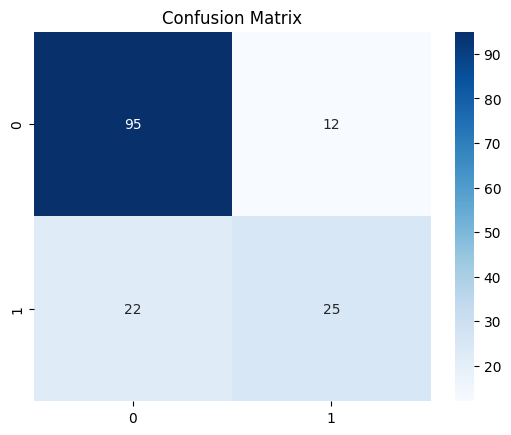

In [10]:
best_pruning_model = DecisionTreeClassifier(**tree_study.best_params, random_state=0)
best_pruning_model.fit(X_train, y_train)
best_tree_f1_train = f1_score(y_train, best_pruning_model.predict(X_train),average='macro')
best_tree_f1_test = f1_score(y_test, best_pruning_model.predict(X_test),average='macro')

print('train f1:',best_tree_f1_train)
print('test f1:',best_tree_f1_test)

conf_matrix = confusion_matrix(y_test, best_pruning_model.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

An f1 of 0.72 is close to the unpruned decision tree, from the original decision tree! However the train f1 is much lower than before, so not as much as overfitting anymore.

### Resampling

Let's see how different resampling techniques affect the performance!

**Random undersampling:**

test f1: 0.7005555555555556


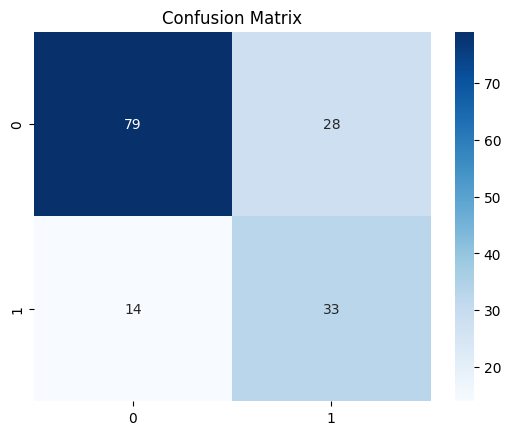

In [14]:
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
#using optimised parameters to make results more comparable,
#although the best parameters would also change slightly with different sampling,
tree = DecisionTreeClassifier(**tree_study.best_params, random_state=0)
tree.fit(X_train_rus, y_train_rus)
rus_f1_test =  f1_score(y_test, tree.predict(X_test), average='macro')

print('test f1:',rus_f1_test)

conf_matrix = confusion_matrix(y_test, tree.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The performance is slightly below the optimised tree.

**Random Oversampler:**

test f1: 0.7353951890034365


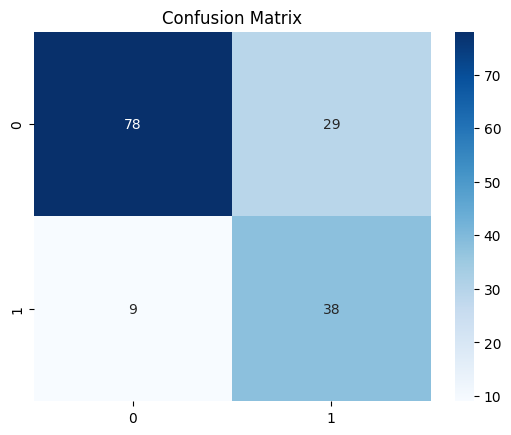

In [15]:
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

tree = DecisionTreeClassifier(**tree_study.best_params, random_state=0)
tree.fit(X_train_ros, y_train_ros)
ros_f1_test =  f1_score(y_test, tree.predict(X_test), average='macro')

print('test f1:',ros_f1_test)

conf_matrix = confusion_matrix(y_test, tree.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The oversampler's performance is slightly above the optimised tree and the undersampler.

**SMOTE:**

test f1: 0.6937287311618863


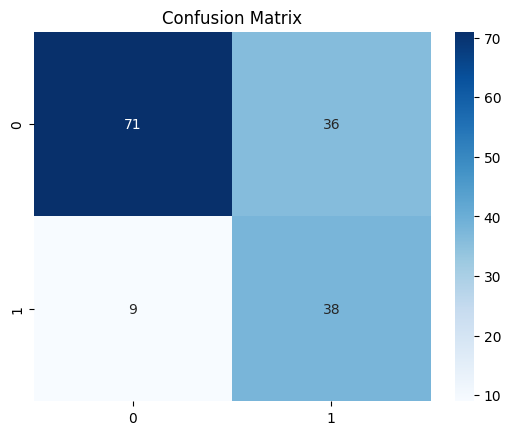

In [16]:
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

tree = DecisionTreeClassifier(**tree_study.best_params, random_state=0)
tree.fit(X_train_smote, y_train_smote)
smote_f1_test =  f1_score(y_test, tree.predict(X_test), average='macro')

print('test f1:',smote_f1_test)

conf_matrix = confusion_matrix(y_test, tree.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The SMOTE performance is worse than both of the under- and oversampler.

### Random Forest and XGBoost

test f1: 0.731891321551042


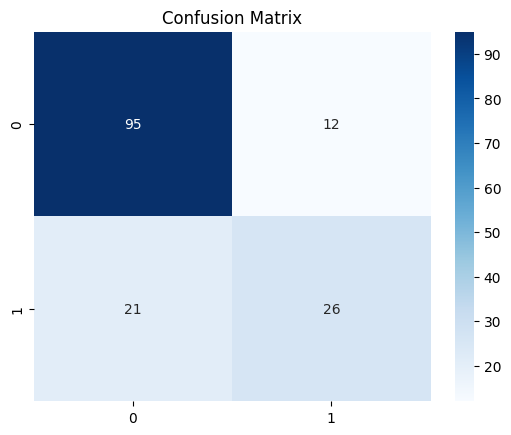

In [17]:
rf_model = RandomForestClassifier(n_estimators=30, random_state=0)
rf_model.fit(X_train, y_train)

rf_f1 =  f1_score(y_test, rf_model.predict(X_test), average='macro')

print('test f1:',rf_f1)

conf_matrix = confusion_matrix(y_test, rf_model.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The unoptimised forest's performance is similar to all the above models.

What are the most important features of the random forest?

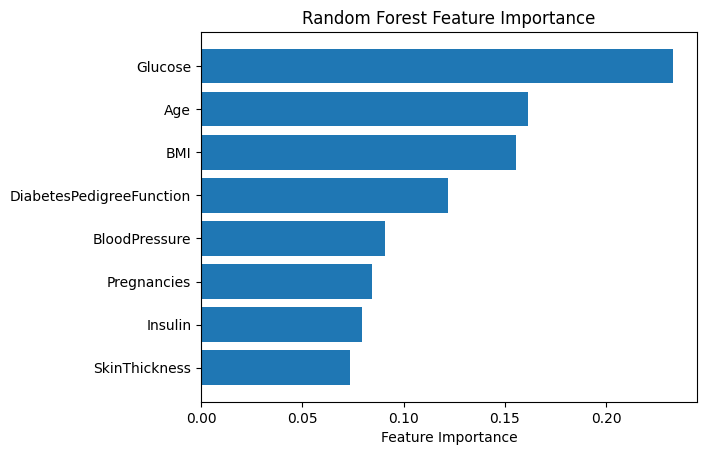

In [18]:
feature_importances = rf_model.feature_importances_
feature_names = list(X_train.columns)

sorted_idx = feature_importances.argsort()

plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

Glucose levels, Age and BMI having the highest importance in predicting diabetes.

test f1: 0.8139287612971824


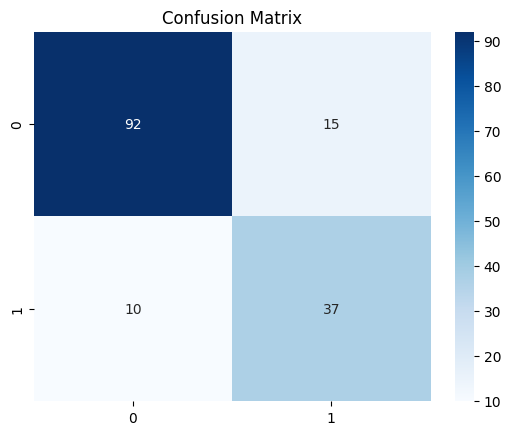

In [19]:
xgbcls_model = XGBClassifier(n_estimators=50, random_state=0)
xgbcls_model.fit(X_train, y_train)

xgb_f1 =  f1_score(y_test, xgbcls_model.predict(X_test), average='macro')
print('test f1:',xgb_f1)

conf_matrix = confusion_matrix(y_test, xgbcls_model.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The XGBoost model has the best performance so far.

Checking the feature importances of the XGBoost model:

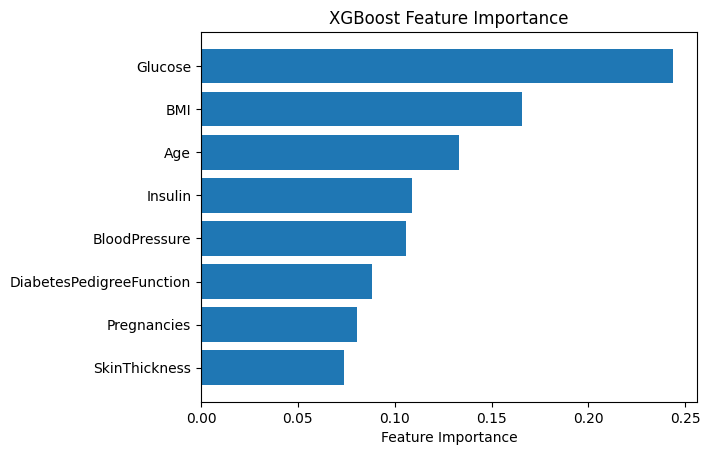

In [20]:
feature_importances = xgbcls_model.feature_importances_
feature_names = list(X_train.columns)

sorted_idx = feature_importances.argsort()[-20:]

plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

Feature importances of XGboost and random forest are rather similar!

Let's compare the train and validation performance of all the models used: Decision Tree, Random Forest and XGBoost!
The best decision tree model was already determined,
so now the same has to happen with random forest and XGBoost.

In [23]:
#Random Forest Optimisation:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    
    model = RandomForestClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_test)
    return f1_score(y_test, y_val_pred, average='macro')

forest_study = optuna.create_study(direction='maximize')
forest_study.optimize(objective, n_trials=50)

best_forest_model = RandomForestClassifier(**forest_study.best_params, random_state=0)
best_forest_model.fit(X_train, y_train)
best_forest_f1_train = f1_score(y_train, best_forest_model.predict(X_train))
best_forest_f1_test = f1_score(y_test, best_forest_model.predict(X_test))

[I 2025-04-03 11:48:03,171] A new study created in memory with name: no-name-aae1bed0-d589-461c-ac09-79af0a27e496
[I 2025-04-03 11:48:03,277] Trial 0 finished with value: 0.7837416133562178 and parameters: {'n_estimators': 56, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.7837416133562178.
[I 2025-04-03 11:48:03,736] Trial 1 finished with value: 0.767512077294686 and parameters: {'n_estimators': 280, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.7837416133562178.
[I 2025-04-03 11:48:03,848] Trial 2 finished with value: 0.7772727272727272 and parameters: {'n_estimators': 77, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.7837416133562178.
[I 2025-04-03 11:48:04,249] Trial 3 finished with value: 0.79592252803

In [26]:
#XGBoost Optimisation:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        }
    
    model = XGBClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_test)
    return f1_score(y_test, y_val_pred, average='macro')


xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(objective, n_trials=50)

best_xgb_model = XGBClassifier(**xgb_study.best_params, random_state=0)
best_xgb_model.fit(X_train, y_train)
best_xgb_f1_train = f1_score(y_train, best_xgb_model.predict(X_train))
best_xgb_f1_test = f1_score(y_test, best_xgb_model.predict(X_test))

[I 2025-04-03 11:48:41,290] A new study created in memory with name: no-name-fa5211d0-2f0c-4e61-95ee-2517eaf7a91c
[I 2025-04-03 11:48:41,463] Trial 0 finished with value: 0.7716554264122064 and parameters: {'n_estimators': 345, 'max_depth': 3, 'learning_rate': 0.14326234304017796}. Best is trial 0 with value: 0.7716554264122064.
[I 2025-04-03 11:48:41,747] Trial 1 finished with value: 0.799043062200957 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.019723447480537195}. Best is trial 1 with value: 0.799043062200957.
[I 2025-04-03 11:48:41,963] Trial 2 finished with value: 0.7667464699272 and parameters: {'n_estimators': 417, 'max_depth': 7, 'learning_rate': 0.27119438864148915}. Best is trial 1 with value: 0.799043062200957.
[I 2025-04-03 11:48:42,213] Trial 3 finished with value: 0.7692716640085061 and parameters: {'n_estimators': 237, 'max_depth': 10, 'learning_rate': 0.0532318175457115}. Best is trial 1 with value: 0.799043062200957.
[I 2025-04-03 11:48:42,3

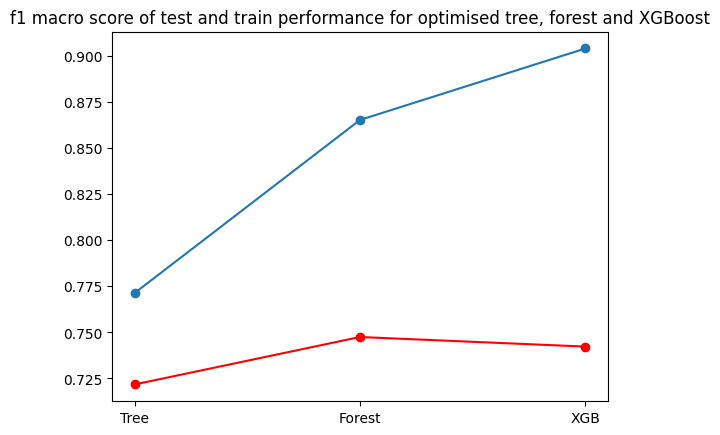

In [27]:
plt.plot(['Tree','Forest','XGB'],[best_tree_f1_train,
best_forest_f1_train, best_xgb_f1_train], marker='o')
plt.plot(['Tree','Forest','XGB'],[best_tree_f1_test,
best_forest_f1_test, best_xgb_f1_test], marker='o', color='r')
plt.title('f1 macro score of test and train performance for optimised tree, forest and XGBoost')
plt.show()

The best test performance is reached by the forest. The tree model is least overfitting though.

### Ensemble

How do different ensemble methods affect the performance?

**Bagging:**

In [40]:
knn_model = KNeighborsClassifier(n_neighbors=7)

bagging_model = BaggingClassifier(estimator=knn_model,n_estimators=100,
    bootstrap=True,bootstrap_features=False, random_state=0)

bagging_model.fit(X_train, y_train)
y_pred = bagging_model.predict(X_test)

f1_train = f1_score(y_train, bagging_model.predict(X_train))
f1_test = f1_score(y_test, y_pred)
print('f1 train:',f1_train)
print('f1 test:', f1_test)

f1 train: 0.683291770573566
f1 test: 0.6304347826086957


**Voting:**

In [35]:
best_xgb_model = XGBClassifier(**xgb_study.best_params, random_state=0)
best_forest_model = RandomForestClassifier(**forest_study.best_params, random_state=0)
best_tree_model = DecisionTreeClassifier(**tree_study.best_params, random_state=0)
base_models = [('bagging',bagging_model),
        ('xgb', best_xgb_model),
        ('rf', best_forest_model),
        ('tree', best_tree_model)]
voting_model = VotingClassifier(estimators = base_models)
voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_test)
f1_train = f1_score(y_train, voting_model.predict(X_train))
f1_test = f1_score(y_test, y_pred)
print('f1 train:',f1_train)
print('f1 test:',f1)

f1 train: 0.8255528255528255
f1 test: 0.7333333333333333


The performance of this voting ensemble is roughly similar to the performance of the worst model of the four (the random forest).

**Stacking:**

In [36]:
meta_model = LogisticRegression(random_state=0)
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
f1_train = f1_score(y_train, stacking_model.predict(X_train))
f1_test = f1_score(y_test, y_pred)
print('f1 train:',f1_train)
print('f1 test:',f1_test)

f1 train: 0.8685446009389671
f1 test: 0.7333333333333333


Out of the three ensemble models, the stacking ensemble had the best performance, although none of the ensembles improve the performance significantly, and the individual models have better results most of the time.